# **PART A**

In [12]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import os
from glob import glob
import cv2
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tflearn.datasets.oxflower17 as oxflower17
from skimage.color import rgb2gray
from sklearn.linear_model import LogisticRegression

# Initialize the random number generator
import random
random.seed(7)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")
tf.__version__

import time

## **1. Import and Understand the data**

### **A. Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python.**

In [15]:
images_path = "./plant-seedlings-classification.zip"

In [16]:
from zipfile import ZipFile
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

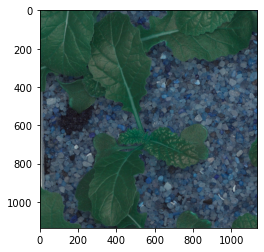

In [76]:
import cv2
import matplotlib.pyplot as plt
test_image = cv2.imread('./0d5f555a3.png')
plt.imshow(test_image)

### **B. Map the images from train folder with train labels to form a DataFrame.**

In [80]:
%%time

training_data_folder = "plant-seedlings-classification/train"

Image_Data=[]
for class_folder_name in os.listdir(training_data_folder):
    class_folder_path = os.path.join(training_data_folder, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        imageName=image_path.split('/')[-1]
        data=[imageName, image, class_folder_name]
        Image_Data.append(data)
        del data

# df creation
plant_df = pd.DataFrame(Image_Data,columns=['Name of Image','Actual Image','Species'])

CPU times: user 25 s, sys: 3.1 s, total: 28 s
Wall time: 30.9 s


In [81]:
plant_df.head()

Name of Image                                       Actual Image   Species
0  6a4ef17c2.png  [[[45, 61, 72], [50, 66, 73], [28, 47, 49], [2...  Cleavers
1  0515bc601.png  [[[146, 156, 161], [146, 156, 162], [147, 156,...  Cleavers
2  0ac327873.png  [[[67, 78, 91], [63, 73, 88], [63, 74, 88], [6...  Cleavers
3  94f82e916.png  [[[45, 62, 80], [42, 57, 78], [46, 60, 81], [4...  Cleavers
4  2c5c4d127.png  [[[62, 98, 137], [59, 96, 135], [62, 97, 136],...  Cleavers

In [82]:
plant_df.Species.unique()

array(['Cleavers', 'Sugar beet', 'Common Chickweed', 'Loose Silky-bent',
       'Scentless Mayweed', 'Shepherds Purse', 'Fat Hen', 'Common wheat',
       'Black-grass', 'Small-flowered Cranesbill', 'Charlock', 'Maize'],
      dtype=object)

### **C. Write a function that will select n random images and display images along with its species**

In [83]:
# display image(s)
def display_images(indexes, rows, cols):
    plt.figure(figsize = (12, 12))
    i = 0
    while len(indexes) > i:
        plt.subplot(rows,cols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        index = indexes[i]
        plt.imshow(Image_Data[index][1],cmap=plt.cm.binary)
        plt.xlabel(Image_Data[index][2])
        i+=1

In [84]:
# display n random images
def display_random_images(n, rows, cols):
    indexes = []
    while n > 0:
        indexes.append(randint(0,4750))
        n-=1
    display_images(indexes, rows, cols)

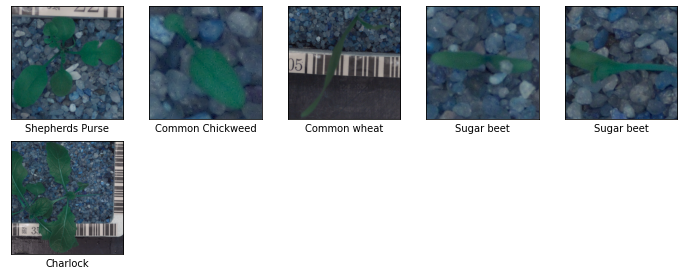

In [85]:
# displaying 6 random images along with its species
display_random_images(6,5,5)

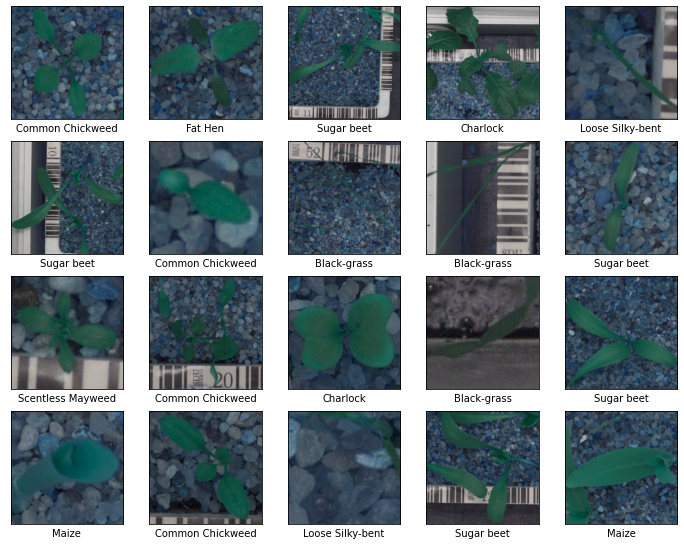

In [86]:
# displaying 20 random images along with its species
display_random_images(20,5,5)

In [87]:
del Image_Data

## **2. Data preprocessing**

### **A. Create X & Y from the DataFrame.**

In [88]:
# Create X & Y from the DataFrame
X = plant_df.drop(labels= 'Species' , axis = 1)
y = plant_df['Species']

In [89]:
# del plant_df

### **B. Encode labels of the images.**

In [90]:
# Encoding labels
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [91]:
y

array([2, 2, 2, ..., 7, 7, 7])

In [92]:
y = tf.keras.utils.to_categorical(y)
y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### **C. Unify shape of all the images**

In [93]:
X.drop('Name of Image', axis=1, inplace=True)
print(X.shape)
print(y.shape)

(4750, 1)
(4750, 12)


In [94]:
list_data = X.iloc[:,0].tolist()

In [95]:
list_data[0]

array([[[ 45,  61,  72],
        [ 50,  66,  73],
        [ 28,  47,  49],
        ...,
        [ 48,  70,  89],
        [ 50,  72,  92],
        [ 53,  75,  96]],

       [[ 43,  59,  68],
        [ 42,  58,  62],
        [ 25,  44,  43],
        ...,
        [ 58,  77,  95],
        [ 58,  77,  97],
        [ 58,  78,  98]],

       [[ 39,  55,  61],
        [ 33,  49,  52],
        [ 24,  42,  40],
        ...,
        [ 61,  78,  97],
        [ 61,  79,  98],
        [ 64,  82, 102]],

       ...,

       [[ 71,  89, 104],
        [ 72,  90, 106],
        [ 76,  93, 109],
        ...,
        [ 39,  56,  72],
        [ 37,  54,  71],
        [ 39,  56,  72]],

       [[ 87, 105, 120],
        [ 83, 101, 116],
        [ 76,  94, 110],
        ...,
        [ 39,  56,  72],
        [ 38,  55,  71],
        [ 36,  53,  71]],

       [[ 69,  88, 105],
        [ 73,  92, 108],
        [ 73,  91, 107],
        ...,
        [ 39,  55,  71],
        [ 38,  54,  71],
        [ 37,  53,  71]]

In [96]:
len(list_data)

4750

In [97]:
%%time

# Unify shape of all the images
train=[]
for i in X.iloc[:,0].tolist():
    train.append(cv2.resize(i,(256,256)))

X_reshaped = np.asarray(train)

CPU times: user 1.37 s, sys: 504 ms, total: 1.87 s
Wall time: 1.91 s


In [98]:
X_reshaped.shape

(4750, 256, 256, 3)

### **D. Normalise all the images**

In [99]:
%%time

# Normalising images
X_reshaped = X_reshaped/255

CPU times: user 2.68 s, sys: 3.74 s, total: 6.42 s
Wall time: 11.2 s


In [100]:
X_reshaped

array([[[[0.17647059, 0.23921569, 0.26666667],
         [0.10196078, 0.18039216, 0.17254902],
         [0.08627451, 0.17647059, 0.14509804],
         ...,
         [0.28235294, 0.35686275, 0.41960784],
         [0.20784314, 0.28627451, 0.35686275],
         [0.21568627, 0.29411765, 0.37647059]],

        [[0.14901961, 0.20784314, 0.22352941],
         [0.08235294, 0.15686275, 0.14509804],
         [0.08235294, 0.17254902, 0.14117647],
         ...,
         [0.32156863, 0.39607843, 0.46666667],
         [0.22745098, 0.29411765, 0.37254902],
         [0.24313725, 0.30980392, 0.38823529]],

        [[0.12156863, 0.18431373, 0.19215686],
         [0.10588235, 0.18823529, 0.17254902],
         [0.09411765, 0.18823529, 0.15686275],
         ...,
         [0.3254902 , 0.39215686, 0.46666667],
         [0.22745098, 0.28627451, 0.36862745],
         [0.23921569, 0.29803922, 0.38039216]],

        ...,

        [[0.2627451 , 0.3254902 , 0.4       ],
         [0.27058824, 0.3372549 , 0.40784314]

In [101]:
# memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize

# import psutil
# import humanize
# import os
# import GPUtil as GPU

# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#     process = psutil.Process(os.getpid())
#     print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
#     print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

## **3. Model training**

In [102]:
def model_processing(model, X_train, y_train, X_test):
  # fit model
  model.fit(X_train,y_train)

  # model predict
  y_pred=model.predict(X_test)

  return model, y_pred

In [104]:
#Performance metrics -MICRO/MACRO/WEIGHTED/SAMPLES
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

average_types = ['micro', 'weighted', 'macro']

"""
:param y_val
:param predicted

This method prints the performace metrices.

"""
def print_performance_scores(y_val, predicted):
  for average_type in average_types:
      print('----------------'+average_type+'--------------------------')
      print('Accuracy score: ', accuracy_score(y_val, predicted))
      print('Recall score: ', recall_score(y_val, predicted, average=average_type))
      print('F1 score: ', f1_score(y_val, predicted, average=average_type))
      print('Precision score: ', precision_score(y_val, predicted, average=average_type))

In [105]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
lb = LabelBinarizer()

def model_reports(y_test, y_pred):
  # print classification report
  print('classification report:')
  print(classification_report(y_test, y_pred))
  print('\n')
  print_performance_scores(y_test, y_pred)

  new_y_test = lb.fit_transform(y_test)
  new_y_pred = lb.transform(y_pred)
  print('---------------- ROC-AUC --------------------------')
  print('ROC-AUC score:', roc_auc_score(new_y_test, new_y_pred, average='weighted'))

### **A. Split the data into train and test data.**

In [106]:
%%time

# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2,random_state=4)

CPU times: user 3.54 s, sys: 10.8 s, total: 14.3 s
Wall time: 27 s


In [107]:
# CNN model
image_size=256

# Clear out tensorflow memory
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()

# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# Here we add a 2D Convolution layer
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu',padding='same'))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu',padding='same'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

model.add(tf.keras.layers.Dropout(0.3))

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu', padding='same'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
model.add(tf.keras.layers.Dropout(0.2))

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu', padding='same'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Global Max Pool layer
model.add(tf.keras.layers.GlobalMaxPool2D())

model.add(tf.keras.layers.Dense(64, activation='relu'))

# Dropout
# is used to nullify the outputs that are very close to zero and thus can cause overfitting.
model.add(tf.keras.layers.Dropout(0.2))

#Add Output Layer
model.add(tf.keras.layers.Dense(12, activation='softmax')) # = 12 predicted classes

In [108]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [109]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1

### **C. Train the model on train data and validate on test data.**

In [110]:
%%time

#ImageDataGenerator declaration 
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=50,  
                                                          width_shift_range=0.1,  
                                                          height_shift_range=0.1,  
                                                          horizontal_flip=True, 
                                                          shear_range=0.2,
                                                          zoom_range=0.2,  
                                                          fill_mode="nearest")  

# Prepare the generator
datagen.fit(X_train)

CPU times: user 3.31 s, sys: 16 s, total: 19.3 s
Wall time: 34.2 s


In [111]:
# export MKLDNN_VERBOSE=1

In [112]:
# model training
%%time

model.fit(datagen.flow(X_train,y_train,batch_size=32),
                    steps_per_epoch=X_train.shape[0]/32,
                    epochs=50,
                    validation_data=(X_test,y_test),
                    verbose=1)

Epoch 1/50
118/118 [==============================] - 456s 4s/step - batch: 59.0000 - size: 31.9328 - loss: 2.4482 - acc: 0.1382 - val_loss: 2.4715 - val_acc: 0.1558
Epoch 2/50
118/118 [==============================] - 464s 4s/step - batch: 59.0000 - size: 31.9328 - loss: 2.4073 - acc: 0.1463 - val_loss: 2.4346 - val_acc: 0.1537
Epoch 3/50
118/118 [==============================] - 457s 4s/step - batch: 59.0000 - size: 31.9328 - loss: 2.3824 - acc: 0.1592 - val_loss: 2.3808 - val_acc: 0.2221
Epoch 4/50
118/118 [==============================] - 460s 4s/step - batch: 59.0000 - size: 31.9328 - loss: 2.1518 - acc: 0.2750 - val_loss: 2.0005 - val_acc: 0.3411
Epoch 5/50
118/118 [==============================] - 442s 4s/step - batch: 59.0000 - size: 31.9328 - loss: 1.9398 - acc: 0.3279 - val_loss: 1.8249 - val_acc: 0.3547
Epoch 6/50
118/118 [==============================] - 426s 4s/step - batch: 59.0000 - size: 31.9328 - loss: 1.8762 - acc: 0.3445 - val_loss: 1.7295 - val_acc: 0.4221
Epoc

In [113]:
val_score = model.evaluate(X_test,y_test, verbose=0)
print('Test data score: ', val_score[1])

Test data score:  0.8821053


### **D. Select a random image and print actual label and predicted label for the same.**

value:  32
Actual Label for plant image:  2
CNN model predicted the image to belong to class:  [2]


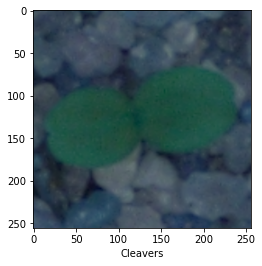

In [114]:
value = randint(0,4750)
print('value: ',value)
pred_image = X_reshaped[value]

plt.imshow(pred_image,cmap=plt.cm.binary)
plt.xlabel(plant_df['Species'][value])
print("Actual Label for plant image: ", np.argmax(y[value] ,axis=0))

pred_image = np.expand_dims(pred_image, axis=0)

prediction = model.predict(pred_image)
print("CNN model predicted the image to belong to class: ", np.argmax(prediction ,axis=1))

In [115]:
y_predicted = model.predict(X_test)
y_pred_labels = [np.argmax(i) for i in y_predicted]

In [116]:
# model report
model_reports((np.argmax(y_test ,axis=1)), y_pred_labels)

classification report:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69        55
           1       0.78      0.91      0.84        68
           2       0.87      0.93      0.90        56
           3       0.92      0.89      0.90       131
           4       0.83      1.00      0.91        43
           5       1.00      0.93      0.96        86
           6       0.90      0.77      0.83       113
           7       1.00      0.92      0.96        51
           8       0.95      0.94      0.94       111
           9       0.93      0.57      0.70        44
          10       0.99      0.92      0.95       115
          11       0.76      0.96      0.85        77

    accuracy                           0.88       950
   macro avg       0.88      0.87      0.87       950
weighted avg       0.89      0.88      0.88       950



----------------micro--------------------------
Accuracy score:  0.8821052631578947
Recall score:  0.8821052

Confusion Matrix


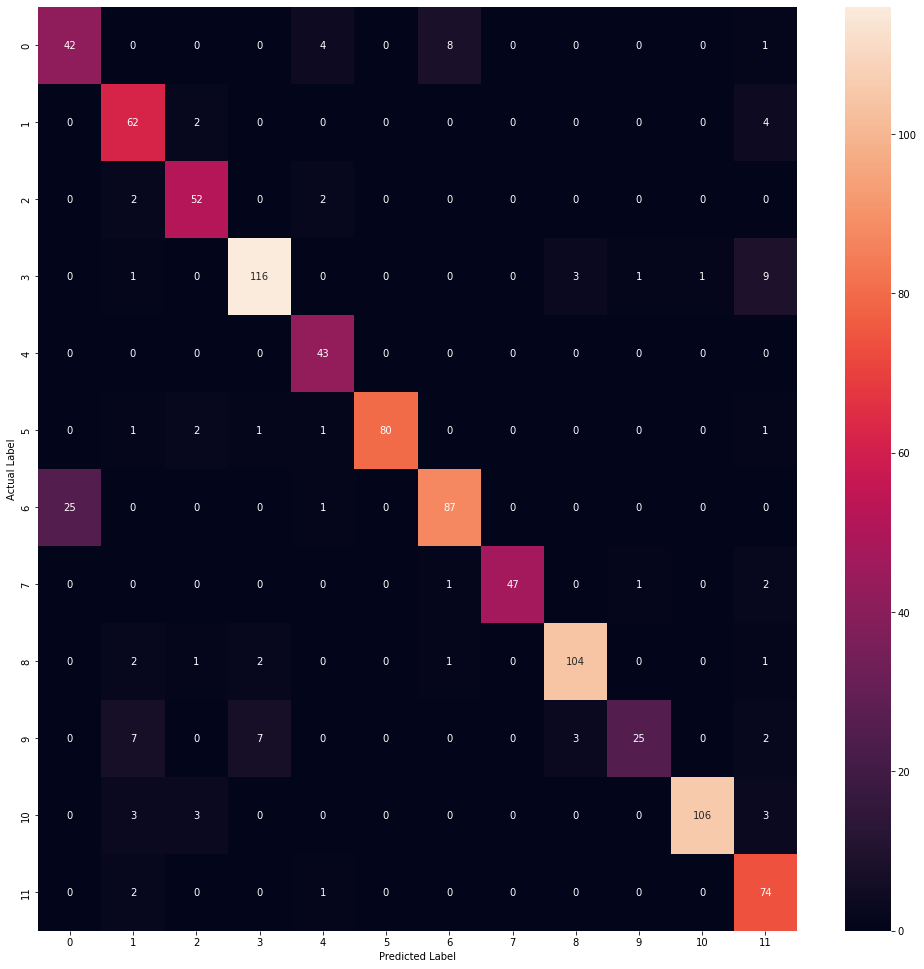

In [117]:
# confusion matrix
confusion_matrix(y_test, y_pred_labels)

**__Observations__**:

* Process consuming too much RAM while running in Colab and that's lead to frequent crash - so ended up working in jyupter.

* Model training took approx : 6-8 hours.

* Finally using this model we were able to achieve 88% accuracy.

* ROC-AUC score for model is pretty good - which is (0.93)

# PART - B

## 1. Import and Understand the data

### A. Import and read oxflower17 dataset from tflearn and split into X and Y while loading.

In [119]:
# Import and read oxflower17 dataset
X, y = oxflower17.load_data(resize_pics=(224,224))

### B. Print Number of images and shape of the images. 

In [120]:
# Print Number of images and shape of the images.
print('Number of images: ', y.shape)
print('Shape of images: ', X.shape)

Number of images:  (1360,)
Shape of images:  (1360, 224, 224, 3)


In [121]:
X[:1]

array([[[[0.36078432, 0.3137255 , 0.15686275],
         [0.3647059 , 0.32941177, 0.16862746],
         [0.30980393, 0.29411766, 0.14901961],
         ...,
         [0.1764706 , 0.2       , 0.09803922],
         [0.16862746, 0.19215687, 0.09019608],
         [0.15686275, 0.18039216, 0.07843138]],

        [[0.39607844, 0.34901962, 0.19607843],
         [0.37254903, 0.3372549 , 0.18039216],
         [0.30980393, 0.29411766, 0.14901961],
         ...,
         [0.15686275, 0.1764706 , 0.08235294],
         [0.15686275, 0.18039216, 0.08627451],
         [0.16078432, 0.18039216, 0.08627451]],

        [[0.3882353 , 0.34509805, 0.19215687],
         [0.35686275, 0.32156864, 0.17254902],
         [0.30980393, 0.29411766, 0.15294118],
         ...,
         [0.15686275, 0.1764706 , 0.08627451],
         [0.15294118, 0.1764706 , 0.08235294],
         [0.15294118, 0.17254902, 0.08235294]],

        ...,

        [[0.18431373, 0.19607843, 0.16862746],
         [0.05098039, 0.0627451 , 0.03529412]

In [122]:
y

array([12,  4,  8, ..., 10,  8,  0])

In [123]:
y[:10]

array([12,  4,  8, 11, 15,  7, 10,  7,  3, 15])

### C. Print count of each class from y. 

In [124]:
value_counts = []
for i in set(y):
    value_counts.append(len(X[y == i]))
    
for class_type in set(y):
    print("Count of images in class_type {0} -> {1}".format(class_type, value_counts[class_type]))

Count of images in class_type 0 -> 80
Count of images in class_type 1 -> 80
Count of images in class_type 2 -> 80
Count of images in class_type 3 -> 80
Count of images in class_type 4 -> 80
Count of images in class_type 5 -> 80
Count of images in class_type 6 -> 80
Count of images in class_type 7 -> 80
Count of images in class_type 8 -> 80
Count of images in class_type 9 -> 80
Count of images in class_type 10 -> 80
Count of images in class_type 11 -> 80
Count of images in class_type 12 -> 80
Count of images in class_type 13 -> 80
Count of images in class_type 14 -> 80
Count of images in class_type 15 -> 80
Count of images in class_type 16 -> 80


## 2. Image Exploration & Transformation 

### A. Display 5 random images. 

In [125]:
# display image(s)
def display_images(imgs, rows, cols, is_gray=False, gray_num=2):
    plt.figure(figsize = (15, 15))
    i = 0
    while len(imgs) > i:
        plt.subplot(rows,cols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = imgs[i]
        plt.imshow(img,cmap= plt.cm.gray if is_gray else plt.cm.binary)
        i+=1

In [126]:
def display_random_images(n, rows, cols):
    imgs = [X[randint(0,1361)] for i in range(n)]
    display_images(imgs, rows, cols)

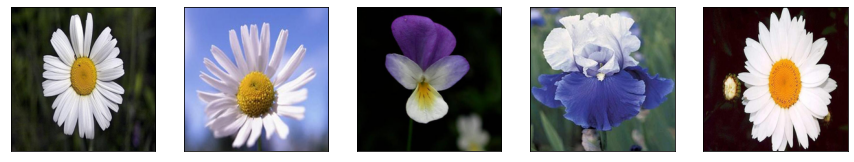

In [127]:
# display 5 random images
display_random_images(5, 1,5)

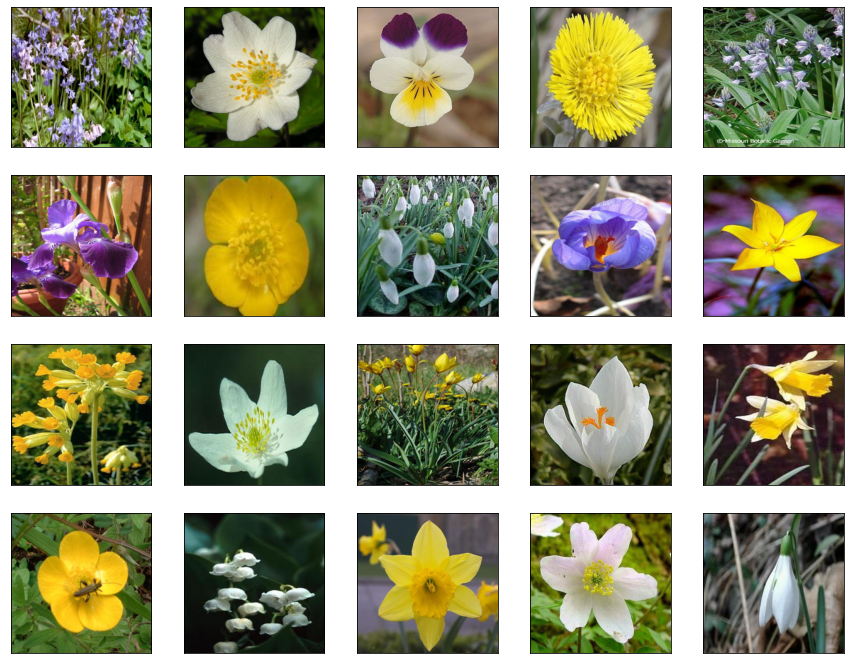

In [128]:
# display 20 random images
display_random_images(20,5,5)

### B. Select any image from the dataset and assign it to a variable.

In [129]:
# Select any image from the dataset and assign it to a variable
img_100 = X[100]

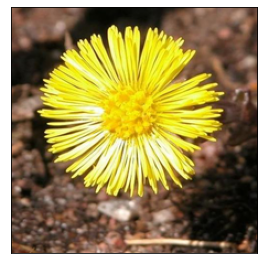

In [130]:
display_images([img_100], 1, 3)

### C. Transform the image into grayscale format and display the same. 

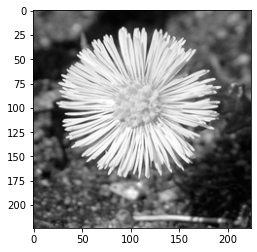

In [131]:
# Transform the image into grayscale format and display the same
gray_scale = rgb2gray(img_100)
plt.imshow(gray_scale, cmap=plt.cm.gray)

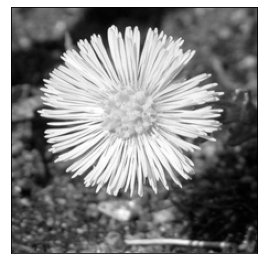

In [132]:
display_images([gray_scale], 1, 3, True, 0)

### D. Apply a filter to sharpen the image and display the image before and after sharpening. 

In [133]:
# filter to sharp the image
sharpen = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

In [134]:
image_sharp = cv2.filter2D(src=img_100, ddepth=-1, kernel=sharpen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


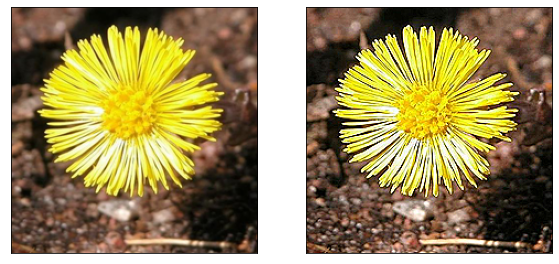

In [135]:
display_images([img_100, image_sharp], 1, 3)

### E. Apply a filter to blur the image and display the image before and after blur. 

In [136]:
# filter to blur the image
ksize = (10, 10)

image_blur = cv2.blur(img_100, ksize)

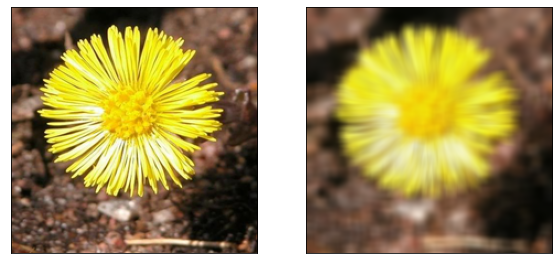

In [137]:
display_images([img_100, image_blur], 1, 3)

### F. Display all the 4 images from above questions besides each other to observe the difference.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


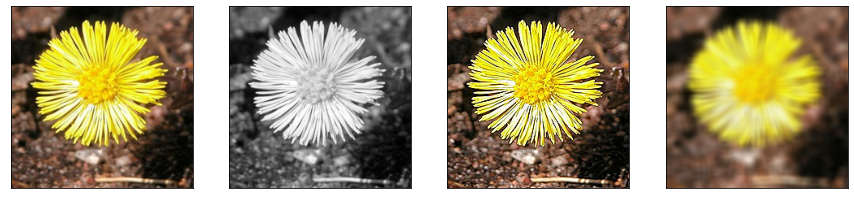

In [138]:
display_images([img_100, gray_scale, image_sharp, image_blur], 1, 4, True, 1)

## 3. Model training and Tuning

### A. Split the data into train and test with 80:20 proportion. 

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state =  100)

In [140]:
X_train.shape

(1088, 224, 224, 3)

In [141]:
X_test.shape

(272, 224, 224, 3)

In [142]:
# assign number of classes to a variable
num_class = 17

In [143]:
#One hot encoding the train labels
y_train = tf.keras.utils.to_categorical(y_train,num_class) 

#One hot encoding the test labels
y_test = tf.keras.utils.to_categorical(y_test,num_class)

In [144]:
#Normalize both the train and test image data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

### B. Train a model using any Supervised Learning algorithm and share performance metrics on test data.

In [145]:
def model_processing(model, X_train, y_train, X_test):
  # fit model
  model.fit(X_train,y_train)

  # model predict
  y_pred=model.predict(X_test)

  return model, y_pred

In [146]:
#Performance metrics -MICRO/MACRO/WEIGHTED/SAMPLES
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

average_types = ['micro', 'weighted', 'macro']

"""
:param y_val
:param predicted

This method prints the performace metrices.

"""
def print_performance_scores(y_val, predicted):
  for average_type in average_types:
      print('----------------'+average_type+'--------------------------')
      print('Accuracy score: ', accuracy_score(y_val, predicted))
      print('Recall score: ', recall_score(y_val, predicted, average=average_type))
      print('F1 score: ', f1_score(y_val, predicted, average=average_type))
      print('Precision score: ', precision_score(y_val, predicted, average=average_type))

In [147]:
# Performance metrics for data
def confusion_matrix(y_test, y_pred):
    print("Confusion Matrix")
    cm=metrics.confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    plt.figure(figsize = (17,17))
    sns.heatmap(cm, annot=True ,fmt='g')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

In [148]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
lb = LabelBinarizer()

def model_reports(y_test, y_pred):
  # print classification report
  print('classification report:')
  print(classification_report(y_test, y_pred))
  print('\n')
  print_performance_scores(y_test, y_pred)

  new_y_test = lb.fit_transform(y_test)
  new_y_pred = lb.transform(y_pred)
  print('---------------- ROC-AUC --------------------------')
  print('ROC-AUC score:', roc_auc_score(new_y_test, new_y_pred, average='weighted'))

In [149]:
# flattens train data
nsamples, nx, ny, nz = X_train.shape
X_train_reshaped = X_train.reshape((nsamples,nx*ny*nz))

In [150]:
# flattens test data
nsamples, nx, ny, nz = X_test.shape
X_test_reshaped = X_test.reshape((nsamples,nx*ny*nz))

In [151]:
%%time

# Train a model using logistic regression
model, y_pred = model_processing(LogisticRegression(solver="liblinear"), X_train_reshaped, (np.argmax(y_train ,axis=1)), X_test_reshaped)

CPU times: user 7min 22s, sys: 4.63 s, total: 7min 27s
Wall time: 2min 52s


In [152]:
model_reports((np.argmax(y_test ,axis=1)), y_pred)

classification report:
              precision    recall  f1-score   support

           0       0.45      0.38      0.42        13
           1       0.80      0.29      0.42        14
           2       0.50      0.87      0.63        15
           3       0.33      0.13      0.19        15
           4       0.41      0.61      0.49        18
           5       0.25      0.06      0.10        17
           6       0.15      0.12      0.14        16
           7       0.46      0.43      0.44        14
           8       0.64      0.60      0.62        15
           9       0.27      0.71      0.39        14
          10       0.33      0.15      0.21        20
          11       0.26      0.64      0.37        14
          12       0.77      0.45      0.57        22
          13       0.00      0.00      0.00        22
          14       0.08      0.08      0.08        12
          15       0.62      0.31      0.42        16
          16       0.32      0.80      0.45        15

   

Confusion Matrix


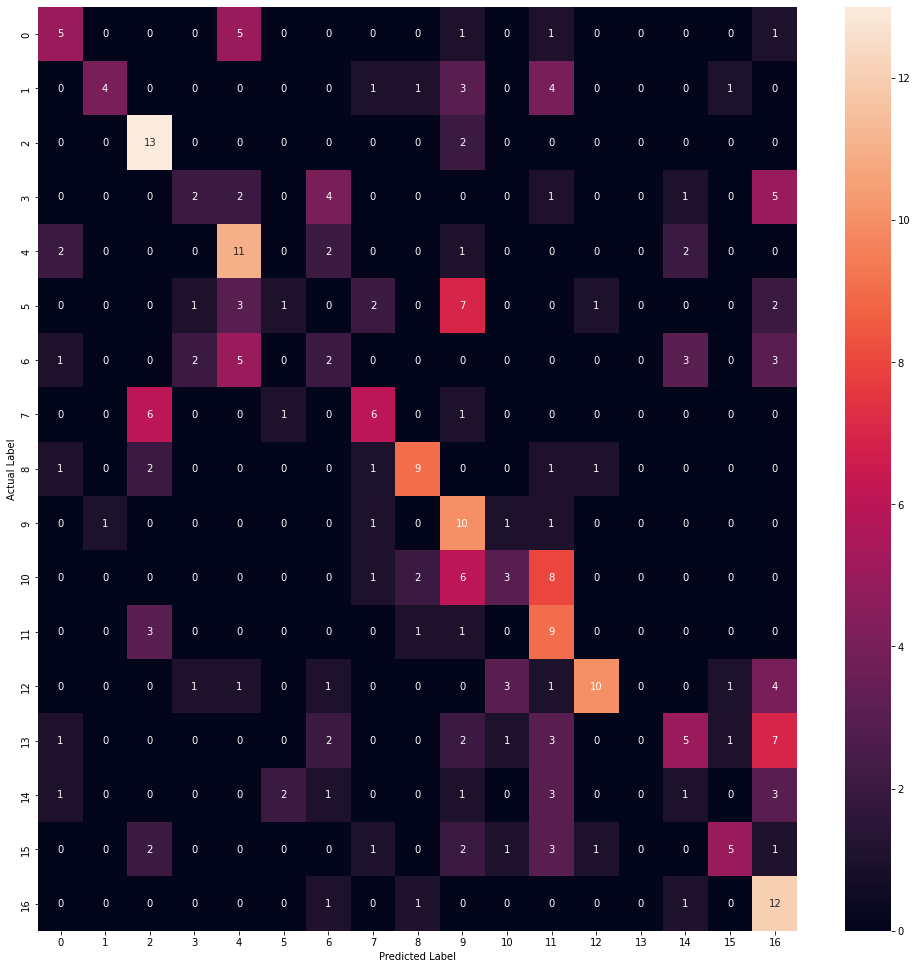

In [153]:
confusion_matrix(y_test, y_pred)

### **C. Train a model using Neural Network and share performance metrics on test data.**

In [154]:
# Clear out tensorflow memory
tf.keras.backend.clear_session()

# Initialize Sequential model
nn_model = Sequential()

# Batch Normalization on data
nn_model.add(BatchNormalization())

# Hidden Layers
nn_model.add(Dense(20, input_shape = (nx*ny*nz, ), activation='relu', name='Layer_1'))

# Dropout Layer
nn_model.add(Dropout(0.3))

# Hidden layers
nn_model.add(Dense(20, activation='relu', name='Layer_2'))
nn_model.add(Dense(15, activation='relu', name='Layer_3'))

# Dropout Layer
nn_model.add(Dropout(0.1))

# Output Layer
nn_model.add(Dense(17, activation='softmax', name='Output'))

In [155]:
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [156]:
%%time

nn_model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=25, batch_size = 32)

Train on 1088 samples, validate on 272 samples
Epoch 1/25
1088/1088 [==============================] - 2s 1ms/sample - loss: 2.7879 - acc: 0.0974 - val_loss: 2.8330 - val_acc: 0.0515
Epoch 2/25
1088/1088 [==============================] - 1s 1ms/sample - loss: 2.6067 - acc: 0.1507 - val_loss: 2.8330 - val_acc: 0.0882
Epoch 3/25
1088/1088 [==============================] - 1s 1ms/sample - loss: 2.5467 - acc: 0.1618 - val_loss: 2.8329 - val_acc: 0.0515
Epoch 4/25
1088/1088 [==============================] - 1s 1ms/sample - loss: 2.4693 - acc: 0.1756 - val_loss: 2.8308 - val_acc: 0.0772
Epoch 5/25
1088/1088 [==============================] - 1s 1ms/sample - loss: 2.3977 - acc: 0.2197 - val_loss: 2.8432 - val_acc: 0.0551
Epoch 6/25
1088/1088 [==============================] - 1s 1ms/sample - loss: 2.2904 - acc: 0.2279 - val_loss: 2.8323 - val_acc: 0.0588
Epoch 7/25
1088/1088 [==============================] - 1s 1ms/sample - loss: 2.2440 - acc: 0.2831 - val_loss: 2.8235 - val_acc: 0.0625
E

In [157]:
nn_model.evaluate(X_test_reshaped, y_test)

[1.7834504632388843, 0.4007353]

In [158]:
y_predicted = nn_model.predict(X_test_reshaped)
y_pred_labels = [np.argmax(i) for i in y_predicted]

In [159]:
model_reports((np.argmax(y_test ,axis=1)), y_pred_labels)

classification report:
              precision    recall  f1-score   support

           0       0.31      0.62      0.41        13
           1       0.29      0.14      0.19        14
           2       0.83      0.67      0.74        15
           3       0.67      0.13      0.22        15
           4       0.67      0.44      0.53        18
           5       0.17      0.12      0.14        17
           6       0.45      0.31      0.37        16
           7       0.55      0.79      0.65        14
           8       0.55      0.80      0.65        15
           9       0.16      0.36      0.22        14
          10       0.24      0.25      0.24        20
          11       0.32      0.50      0.39        14
          12       0.79      0.50      0.61        22
          13       0.67      0.27      0.39        22
          14       0.00      0.00      0.00        12
          15       0.26      0.38      0.31        16
          16       1.00      0.60      0.75        15

   

Confusion Matrix


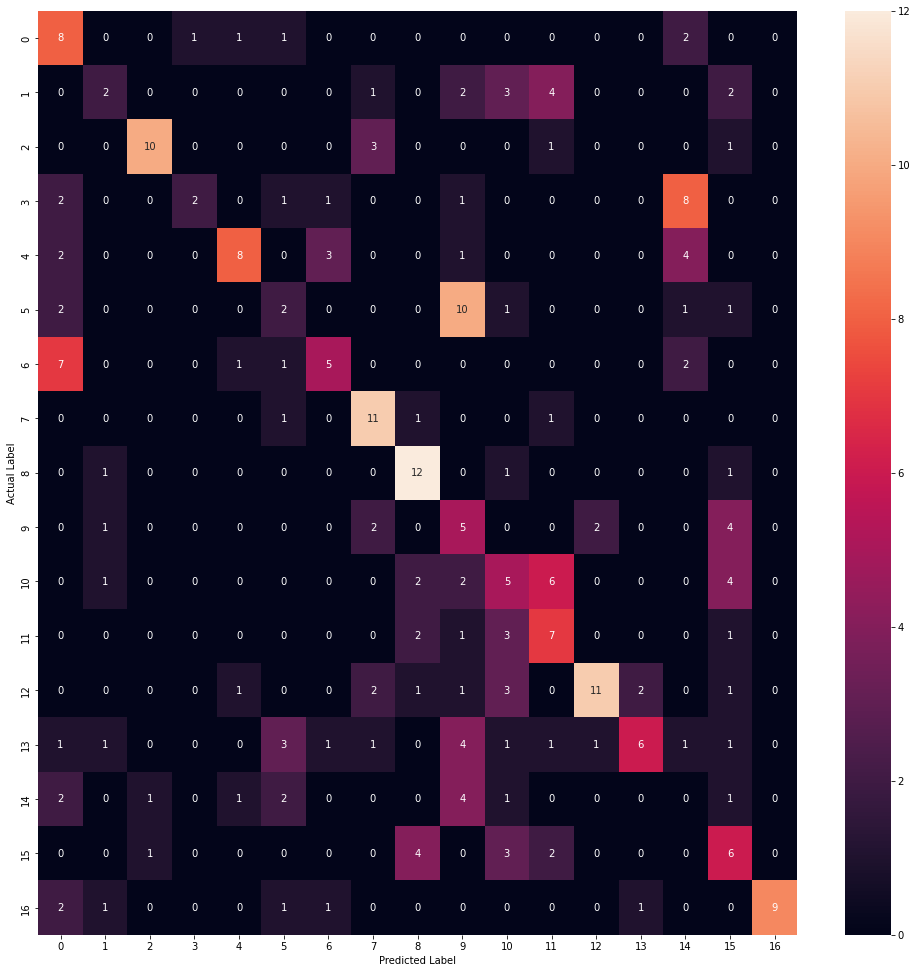

In [160]:
confusion_matrix(y_test, y_pred_labels)

### **D. Train a model using a basic CNN and share performance metrics on test data.**

In [161]:
# Clear out tensorflow memory
tf.keras.backend.clear_session()

# Initialize the model
cnn_model = tf.keras.models.Sequential()

# Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'relu' 
cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(224, 224, 3)))

# Add a MaxPooling Layer of size 2X2 
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'relu' 
cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'))

# Apply Dropout with 0.2 probability 
cnn_model.add(tf.keras.layers.Dropout(rate=0.2))

# Flatten the layer
cnn_model.add(tf.keras.layers.Flatten())

# Add Fully Connected Layer with 128 units and activation function as 'relu'
cnn_model.add(tf.keras.layers.Dense(128, activation="relu"))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
cnn_model.add(tf.keras.layers.Dense(17, activation="softmax"))

In [162]:
cnn_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=5e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [163]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               50466944  
                                                        

In [164]:
#ImageDataGenerator declaration 
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=50,  
                                                          width_shift_range=0.1,  
                                                          height_shift_range=0.1,  
                                                          horizontal_flip=True, 
                                                          shear_range=0.2,
                                                          zoom_range=0.2,  
                                                          fill_mode="nearest")  

# Prepare the generator
datagen.fit(X_train)

In [172]:
%%time

# Train the model on train data and validate on test data.

cnn_model.fit(datagen.flow(X_train,y_train,batch_size=32),
                    steps_per_epoch=X_train.shape[0]/32,
                    epochs=50,
                    validation_data=(X_test,y_test)
                    )

Epoch 1/50
34/34 [==============================] - 31s 903ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.8241 - acc: 0.0625 - val_loss: 2.8082 - val_acc: 0.0919
Epoch 2/50
34/34 [==============================] - 32s 932ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.7755 - acc: 0.0938 - val_loss: 2.6924 - val_acc: 0.1324
Epoch 3/50
34/34 [==============================] - 31s 919ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.6131 - acc: 0.1324 - val_loss: 2.5145 - val_acc: 0.1176
Epoch 4/50
34/34 [==============================] - 32s 933ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.4308 - acc: 0.1884 - val_loss: 2.2431 - val_acc: 0.2757
Epoch 5/50
34/34 [==============================] - 33s 971ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.3079 - acc: 0.2298 - val_loss: 2.1102 - val_acc: 0.3015
Epoch 6/50
34/34 [==============================] - 32s 943ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.1796 - acc: 0.2564 - val_loss: 2.1773 - val_acc: 0.2500
Epoc

In [173]:
cnn_model.evaluate(X_test, y_test, verbose=0)

[1.3727750076967127, 0.50735295]

In [174]:
y_predicted = cnn_model.predict(X_test)
y_pred_labels = [np.argmax(i) for i in y_predicted]

In [175]:
model_reports((np.argmax(y_test ,axis=1)), y_pred_labels)

classification report:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        13
           1       0.50      0.57      0.53        14
           2       0.82      0.93      0.87        15
           3       0.29      0.13      0.18        15
           4       0.35      0.39      0.37        18
           5       0.16      0.24      0.19        17
           6       0.28      0.31      0.29        16
           7       0.53      0.71      0.61        14
           8       0.67      0.80      0.73        15
           9       0.57      0.57      0.57        14
          10       0.75      0.75      0.75        20
          11       0.60      0.21      0.32        14
          12       0.72      0.59      0.65        22
          13       0.40      0.18      0.25        22
          14       0.29      0.50      0.36        12
          15       0.67      0.62      0.65        16
          16       0.63      0.80      0.71        15

   

Confusion Matrix


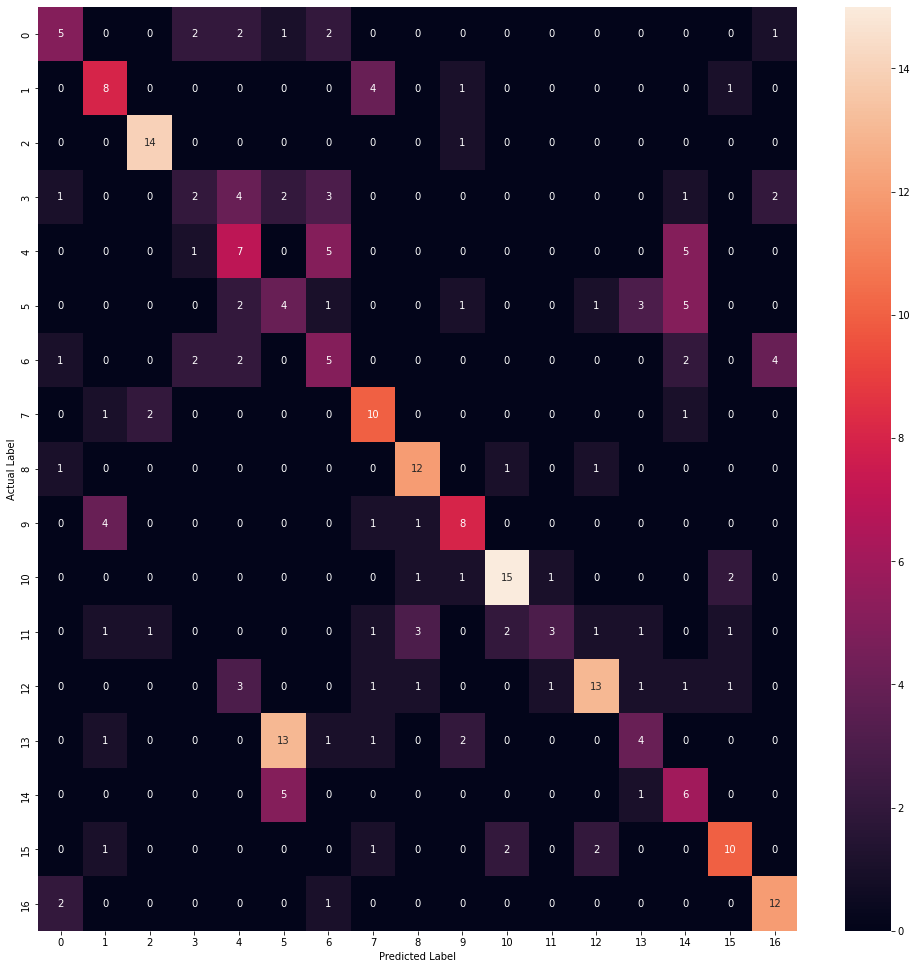

In [176]:
confusion_matrix(y_test, y_pred_labels)

**__Observations__:**

* Different models and accuracy scores
    * Supervised Learning Logistic Regression Model - 37 % with ROC-AUC 0.67
    * Neural Network Model       - 41 % with ROC-AUC 0.69
    * CNN Model - 50 % with ROC-AUC 0.73
* clearly, CNN Model performs well when compared with other models

### **E. Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label.**

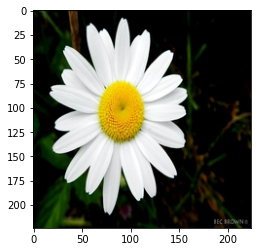

In [177]:
img = plt.imread('Prediction.jpg')

# Resize the image to 224x224x3
image_resize = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
plt.imshow(image_resize)

#Expand the dimensions to 1,224,224,3
image_predict = np.expand_dims(image_resize, axis=0)

In [178]:
prediction = cnn_model.predict(image_predict)
print("CNN model predicted the image to belong to class: ", np.argmax(prediction ,axis=1))

CNN model predicted the image to belong to class:  [2]
